# Lista 5
#### Michał Ilski 250079

#### Własna implementacja przechowywania macierzy

Macierz wejściowa **A** składa się w z bloków mniejszych macierzy typu $A$, $B$ i $C$ oraz zer. Znając układ takiej macierzy (rysunek niżej) można zaproponować wydajny sposób przechowywania jej w pamięci. W tym celu została zaimplementowana struktura *CustomMatrix*, zawierająca wartości *n, l, v* (kolejno rozmiar kwadratowej macierzy **A**, rozmiar bloku i $v=\frac{n}{l}$) oraz listy bloków $A$, $B$ i $C$.

![](1.png)

In [1]:
mutable struct CustomMatrix
    n::Int64
    l::Int64
    v::Int64
    A_blocks::Array{Array{Float64,2},1}
    B_blocks::Array{Array{Float64,2},1}
    C_blocks::Array{Array{Float64,2},1}
    function CustomMatrix(n::Int64, l::Int64)
        v = n/l
        A_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        B_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        C_blocks = [Array{Float64}(zeros(l,l)) for idx in 1:n]
        return new(n, l, v, A_blocks, B_blocks, C_blocks)
    end
end

Funkcja *set_value* służy do ustawiania wartości *value* w macierzy *c* dla komórki o indeksie *[i,j]*. Na podstawie rozmiaru bloku w macierzy *A* oraz indeksie rzędu *i*, możemy określi zakres kolumn, w których możemy dokonać zmiany wartości. Do tego wyznaczam pomocniczą wartość $k = \lfloor\frac{i-1}{l}\rfloor\cdot l$. Ta zmienna wyznacza pierwszą kolumnę, znajdującą się przed blokiem $A$ w rzędzie *i* (w szczególności może być równa $0$, czyli poza macierzą). Następnie sprawdzam, gdzie względem *k* znajduje się indeks $j$ i odpowiednio przechodzę do bloków $A$, $B$, $C$, lub zgłaszam błąd, gdybym wyszedł poza zakres tych bloków. Następnie na podstawie rzędu *i* wybieram odpowiedni blok z listy bloków i ustawiam w nim wartość. Indeksy względne w każdym bloku wyznaczam za pomocą operacji $(i-1)mod(l)+1$ oraz $(j-1)mod(l)+1$, ponieważ indeksowanie w języku Julia odbywa się od $1$ (a nie od $0$).

In [2]:
function set_value(c::CustomMatrix, i::Int64, j::Int64, value::Float64)
    l = c.l
    k = ((i-1)÷l)*l
    if j in k+1:k+l
        c.A_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    elseif j in k-l+1:k
        c.B_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    elseif j in k+l+1:k+2*l
        c.C_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)] = value
    else
         println("ERROR in ", i, " ", j)
    end
end

set_value (generic function with 1 method)

Funkcja *get_value* pobiera wartość z macierzy *c*, z komórki o indeksie *[i,j]*. Zasada dostawania się do komórki jest identyczna jak wyżej, z tą różnicą, że możemy zaglądać poza wyznaczone bloki $A$, $B$ i $C$ - wtedy dostajemy wartość $0$.

In [3]:
function get_value(c::CustomMatrix, i::Int64, j::Int64)
    l = c.l
    k = ((i-1)÷l)*l
    if j in k+1:k+l
        return c.A_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    elseif j in k-l+1:k
        return c.B_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    elseif j in k+l+1:k+2*l
        return c.C_blocks[(i÷l)+1][((i-1)%l+1), ((j-1)%l+1)]
    end
    return 0.0
end

get_value (generic function with 1 method)

#### Funkcja czytająca macierz z pliku  
Funkcja read_matrix na wejściu przyjmuje ścieżkę, w którym znajduje się plik z macierzą oraz nazwę pliku. W funkcji w pierwszej kolejności czytane są wartości $n$ (rozmiar macierzy) oraz $l$ (rozmiar bloków w macierzy głównej). Następnie każda kolejna linia to $i$ (pierwszy indeks macierzy), $j$ (drugi indeks macierzy), $A[i,j]$. Komórki macierzy, dla których nie zostały podane wartości w pliku przyjmują wartość $0$. Zwracana jest wczytana macierz, $n$ oraz $l$.

In [4]:
function read_matrix(folder::String,filename::String)
    path = "$folder/$filename"
    
    open(path, "r") do io
        n, l = (parse(Int64, x) for x in split(readline(io), " "))
        matrix = CustomMatrix(n,l)
        while !eof(io)
            line = split(readline(io), " ")
            i,j,value = (parse(Int64,line[1]), parse(Int64,line[2]), parse(Float64,line[3]))
            set_value(matrix, i, j ,value)
        end
        
        return matrix, n, l
    end    
end

read_matrix (generic function with 1 method)

#### Funkcja czytająca wektor z pliku
Wektor wczytywany jest podobnie jak wyżej. Tutaj jednak jedynymi danymi są długość wektora $n$ oraz jego $n$ wartości. Zwracany jest wektor wraz z wymiarem.

In [5]:
function read_vector(folder::String,filename::String)
    path = "$folder/$filename"
    
    open(path, "r") do io
        n = parse(Int64, readline(io))
        vector = Vector{Float64}(zeros(n))
        for i in 1:n
            vector[i] = parse(Float64, readline(io))
        end
        
        return vector, n
    end    
end

read_vector (generic function with 1 method)

#### Funkcja generująca wektor $b$
Znając macierz $A$ oraz wiedząc, że wektor $x = [1,...,1]^{T}$, możemy samodzielnie wyznaczyć postać wektora $b$. W tym celu wykonuję mnożenie $Ax = b$. W pętli iteruję po wszystkich rzędach, natomiast ze względu na specyficzną postać macierzy $A$, nie muszę iterować po wszystkich kolumnach. Będąc w $i$-tym rzędzie, sumuję wartości w zakresie od $max\{1,l\cdot\lceil\frac{i-l}{l}\rceil\}$ do $min\{n,l\cdot\lceil\frac{i-l}{l}\rceil+l\}$, co obejmuje wartości z bloków $A_x$ i $B_x$ oraz w przypadku, gdy $i+l \leq n$, do $b[i]$ dodaję jeszcze $A[i, i+l]$, czyli bloki $C_x$.

In [6]:
function generate_b_vector(A::CustomMatrix, n::Int64, l::Int64)
    b = Vector{Float64}(zeros(n))
    for i in 1:n
        b[i] = sum(get_value(A,i,Int64(j)) for j in max(1,l*ceil((i-l)/l)):min(n,l*ceil((i-l)/l)+l))
        if i+l <= n
            b[i] += get_value(A,i,i+l)
        end
    end
    return b,n
end

generate_b_vector (generic function with 1 method)

#### Eliminacja Gaussa
Poniższa funkcja wykonuje algorytm eliminacji Gaussa. Na wejściu przyjmowane są: macierz *A*, wektor *b*, rozmiar *n* (macierzy) oraz *l* (bloku). Pętla zewnętrzna iteruje po kolejnych rzędach, wykonująć n-1 iteracji (poza ostatnim rzędem). Wewnętrzna pętla wyznacza mnożnik $l_{i,k} = \frac{a_{i,k}}{a_{k,k}}$, po czym druga wewnętrzna pętla aktualizuje wartości w rzędzie według wzoru: $a_{i,j} = a_{i,j} - l_{i,k}a_{k,j}$. Podobnie wartość w wektorze *b* ulega zmianie: $b_i = b_i - l_{i,k}b_i$. Górnym limitem iteracji może być $min\{k+l, n\}$, ze względu na specyficzną postać macierzy *A* (nie ma sensu liczyć w blokach, gdzie mamy pewność, że są same $0$). Podany algorytm składa się z 3 zagnieżdżonych pętli, których liczbę wykonań można ograniczyć przez rozmiar *n* macierzy. Stąd złożoność takiego algorytmu to $O(n^3)$.

In [7]:
function gaussian_elimination(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    for k in 1:(n-1)
        for i in (k+1):min(k+l, n)
            lik = get_value(A,i,k)/get_value(A,k,k)
            set_value(A,i,k,0.0)
            for j in k+1:min(k+l, n)
                temp = get_value(A,i,j)
                set_value(A,i,j,temp-lik*get_value(A,k,j))
            end
            b[i] -= lik*b[k]
        end
    end       
end

gaussian_elimination (generic function with 1 method)

#### Rozwiązanie równania po wykonaniu eliminacji Gaussa
Funkcja *solve_using_gaussian_elimination* rozwiązuje równanie $Ax=b$, wyznaczając wartość wektora *x*. Funkcja korzysta z postaci macierzy *A* i wektora *b* po przekształceniu z wykorzystaniem funkcji wyżej. W pierwszej kolejności został zainicjowany wektor *x* o rozmiarze *n* (rozmiar wynika bezpośrednio z własności mnożenia macierzy). Następnie pętla rozpoczyna iterację od dolnego rzędu, kierując się w górę macierzy. W pętli wewnętrznej liczona jest wartość danego rzędu macierzy, czyli $s = \sum_{k<j<=min\{n, k+l\}} a_{k,j}x_{j}$, analogicznie jak ma to miejsce podczas mnożenia macierzy razy wektor. Korzystając z wiedzy na temat *b*, wyznaczamy $x_k = \frac{b_{k}-s}{a_{k,k}}$. Limit wewnętrznej pętli można ograniczyć przez $min\{n,k+l\}$ ze względu na specyficzną postać macierzy. Ostatecznie algorytm zawiera dwie pętle (zagnieżdżone), których limit iteracji można ograniczyć z góry przez *n*. Stąd złożoność algorytmu to $O(n^2)$.

In [8]:
function solve_using_gaussian_elimination(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    x = Vector{Float64}(zeros(n))
    for k in n:-1:1
        matrix_sum = 0
        for j = k + 1:min(n, k + l)
            matrix_sum += get_value(A,k,j)*x[j]
        end
        x[k] = (b[k] - matrix_sum)/get_value(A,k,k)
    end
    return x
end

solve_using_gaussian_elimination (generic function with 1 method)

#### Eliminacja Gaussa z wyborem elementu głównego

Poniższa funkcja przypomina zasadą działania podstawową wersję eliminacji Gaussa (tę wyżej). Różnica polega na samodzielnym wyborze elementu głównego w taki sposób, aby był on możliwie daleki od wartości 0, aby generować możliwie małe błędy, powstające podczas wykonywania działań. W tym celu został dodatkowo zainicjowany wektor *order*, który będzie zawierał informacje o indeksach rzędów w macierzy, po przekształceniu jej poprzez wybieranie elementu głównego. W zewnętrznej pętli dodatkowo został dopisany kod, który w liniowym czasie znajduje maksymalną wartość bezwględną w danej kolumnie (poniżej aktualnego rzędu) i zamienia aktualny rząd z macierzy z tym, który zawiera tę wartość. Stosując wektor *order*, będący permutacją indeksów rzędów, nie ma potrzeby przebudowywać macierzy w pamięci. Dalsza część kodu jest analogiczna do implementacji wyżej, przy czym zamiast elementu $a_{i,j}$ wybieramy $a_{order[i],j}$ (podobnie w *b*). W tej implementacji znajduje się dodatkowo pętla wyznacząjąca wartość maksymalną dla danego rzędu o złożoności $O(n)$, co daje wciąż złożoność całego algorytmu $O(n^3)$.

In [9]:
function gaussian_elimination_choose_element(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    order = Vector(1:n)
    
    for k in 1:(n-1)
        current_max, max_id = abs(get_value(A,order[k],k)), k
        for i in (k+1):min(k+l, n)
            if abs(get_value(A,order[i],k)) > current_max
                current_max, max_id = abs(get_value(A,order[i],k)), i
            end
        end
        order[max_id], order[k] = order[k], order[max_id]
        
        for i in (k+1):min(k+l, n)
            lik = get_value(A,order[i],k)/get_value(A,order[k],k)
            set_value(A,order[i],k,0.0)
            for j in k+1:min(k+2*l-((k-1)%l+1), n)
                temp = get_value(A,order[i],j)
                set_value(A,order[i],j,temp-lik*get_value(A,order[k],j))     
            end
            b[order[i]] -= lik*b[order[k]]
        end
    end
    return order
end

gaussian_elimination_choose_element (generic function with 1 method)

#### Rozwiązanie równania po wykonaniu eliminacji Gaussa z wyborem elementu głównego

Rozwiązanie równania z wyborem elementu głównego jest analogiczne do tego, w którym nie wybieramy elementu. Różnica polega braniu wartości z macierzy *A* zgodnie z przekazanym na wejściu porządkiem (zwróconym w funkcji wyżej), tzn. zamiast $a_{i,j}$ bierzemy $a_{order[i],j}$. Na samym końcu chcemy zwrócić *x*, który zostałby wyliczony dla *A* i *b* bez modyfikacji wyboru elementu głównego. W tym celu deklaruję wektor *res* i podpisuję wartości z *x* tak, że ${res_i = x_{order[i]}}$ (w ostaniej pętli). Ostania pętla ma złożoność $O(n)$, co pozostawia złożoność algorytmu $O(n^2)$, jak wyżej.

In [10]:
function solve_using_gaussian_elimination_choose_element(A::CustomMatrix, b::Vector{Float64}, order::Vector{Int64}, n::Int64, l::Int64)
    x = Vector{Float64}(zeros(n))
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k + 1:min(k+2*l, n)
            matrix_sum += get_value(A,order[k],j)*x[j]
        end

        x[k] = (b[order[k]] - matrix_sum)/get_value(A,order[k],k)
    end
    
    res = zeros(n)
    
    for i in 1:n
        res[i] = x[order[i]]
    end

    return x
end

solve_using_gaussian_elimination_choose_element (generic function with 1 method)

#### Rozkład LU

Korzystając z powyższej implementacji eliminacji Gaussa, został napisany rozkład LU dla macierzy *A*. W miejscu dotychczasowej macierzy *A*, będą znajdować się 2 macierze trójkątne L (dolna) oraz U (górna), takie, ze $A = LU$. 
W danej kolumnie *k* przechodzę po wartościach w rzędach niżej i ustawiam $a_{i,k}$ = $l_{i,k}$ (a nie $0$ jak wcześniej). Ponadto nie interesuje mnie tutaj wektor *b*, co jest korzystne, ponieważ jednorazowy rozkład *LU* będę mógł wykorzystać wiele razy. Podobnie jak wyżej, złożoność algorytmu to $O(n^3)$.

In [11]:
function lu(A::CustomMatrix, n::Int64, l::Int64)
    for k in 1:(n-1)
        for i in (k+1):min(k+l, n)
            lik = get_value(A,i,k)/get_value(A,k,k)
            set_value(A,i,k,lik)
            for j in k+1:min(k+l, n)
                temp = get_value(A,i,j)
                set_value(A,i,j,temp-lik*get_value(A,k,j))
            end
        end
    end       
end

lu (generic function with 1 method)

#### Rozwiąznie równania z użyciem rozkładu LU

Rozwiązania równania $Ax=b$, mając *A* w postaci *LU*, można rozbić na rozwiązanie dwóch równań - $Ly=b$ oraz $Ux=y$. Rozwiązywanie obu równań odbywa się analogicznie jak przy macierzy po eliminacji Gaussa. Najpierw rozpatrujemy macierz dolną, czyli iterujemy od górnego rzędu w dół. Zakres iteracji pętli wewnętrznej jest od $max\{1,\lfloor\frac{i-1}{l}\rfloor l\}$ do $i-1$ (czyli ograniczony przez diagonalę). Obliczony *y* przekazujemy niżej do rozwiązania drugiego równania dla macierzy górnej. Tutaj granice iteracji jak dla algorytmu eliminacji Gaussa. Rozwiązanie jednego takiego równania ma złożoność $O(n^2)$. Rozwiązujemy niezależnie 2 takie równania, więc złożoność algorytmu wynosi $O(n^2)$.

In [12]:
function solve_lu(A::CustomMatrix, b::Vector{Float64}, n::Int64, l::Int64)
    
    y = Vector{Float64}(zeros(n))
    for i in 1:n
        matrix_sum = 0.0
        #TODO zmienić
        for j in max(1, Int64(l*floor((i-1)/l))):i-1
            matrix_sum += get_value(A,i,j)*y[j]
        end
        y[i] = b[i] - matrix_sum
    end
    
    x = Vector{Float64}(zeros(n))
    
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k+1:min(n, k+l)
            matrix_sum += get_value(A,k,j)*x[j]
        end
        x[k] = (y[k] - matrix_sum)/get_value(A,k,k)
    end

    return x
end
    
        

solve_lu (generic function with 1 method)

#### Rozkład LU z wyborem elementu głównego

Poniższa funkcja działa analogicznie do powyższej implementacji rozkładu *LU*. Wybór elementu głównego wprowadza konieczność znalezienia wartości w kolumnie możliwie dalekiej od $0$ oraz uwzględnianie nowego porządku elementów podczas sięgania po nie do macierzy (podobnie jak w eliminacji Gaussa z wyborem elementu głównego). Ponownie, wybór elementu głównego nie wpływa na rząd złożoności obliczeniowej danej funkcji, czyli jest równy $O(n^3)$.

In [13]:
function lu_choose_element(A::CustomMatrix, n::Int64, l::Int64)
    order = Vector(1:n)
    
    for k in 1:(n-1)
        current_max, max_id = abs(get_value(A,order[k],k)), k
        for i in (k+1):min(k+l, n)
            if abs(get_value(A,order[i],k)) > current_max
                current_max, max_id = abs(get_value(A,order[i],k)), i
            end
        end
        order[max_id], order[k] = order[k], order[max_id]
        
        for i in (k+1):min(k+l, n)
            lik = get_value(A,order[i],k)/get_value(A,order[k],k)
            set_value(A,order[i],k,lik)
            for j in k+1:min(k+2*l-((k-1)%l + 1), n)
                temp = get_value(A,order[i],j)
                set_value(A,order[i],j,temp-lik*get_value(A,order[k],j))     
            end
        end
    end
    return order
end

lu_choose_element (generic function with 1 method)

#### Rozwiązanie równania z rozkładem LU i wyborem elementu głównego
Funkcja działa analogicznie jak bez wyboru elementu głównego. Jedyna różnica polega na uwzględnieniu nowego porządku podczas sięgania po komórki w macierzy. Złożoność to $O(n^2)$.

In [14]:
function solve_lu_choose_element(A::CustomMatrix, b::Vector{Float64}, order::Vector{Int64}, n::Int64, l::Int64)
    y = Vector{Float64}(zeros(n))
    for i in 1:n
        matrix_sum = 0.0
        for j in max(1, i-2*l):i-1
            matrix_sum += get_value(A,order[i],j)*y[j]
        end
        y[i] = b[order[i]] - matrix_sum
    end
    
    x = Vector{Float64}(zeros(n))
    
    for k = n:-1:1
        matrix_sum = 0.0
        for j = k+1:min(n, k+2*l)
            matrix_sum += get_value(A,order[k],j)*x[j]
        end
        x[k] = (y[k] - matrix_sum)/get_value(A,order[k],k)
    end

    return x
end

solve_lu_choose_element (generic function with 1 method)

#### Wypisywanie rozwiązania
Zgodnie z trecią zadania, poniższa funkcja wypisuje błąd względny oraz wektor wynikowy *x*. W przypadku pustej ścieżki wynik zostanie wypisany na standardowe wyjście.

In [15]:
function write_x(x::Vector{Float64}, n::Int64, generated_b::Bool, path::String)
    if path != ""
        open(path, "w") do file
            if generated_b 
                error = norm(ones(n)-x)/norm(x)
                println(file, error)
            end
            for i = 1:n
                println(file, x[i])
            end
        end
    else
        if generated_b 
            error = norm(ones(n)-x)/norm(x)
            println(error)
        end
        for i = 1:n
            println(x[i])
        end
    end
end

write_x (generic function with 1 method)

### Testy poprawności działania 

In [16]:
using LinearAlgebra #dla funkcji norm

##### n = 16, b wczytywany, eliminacja gaussa

In [17]:
A,n,l = read_matrix("Dane16_1_1/", "A.txt")
b, n = read_vector("Dane16_1_1/", "b.txt")
gaussian_elimination(A,b,n,l)
x = solve_using_gaussian_elimination(A,b,n,l)
write_x(x, n, false, "")

1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000013
0.9999999999999997
0.9999999999999996
0.9999999999999996
0.9999999999999994
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002


##### n = 10000, b generowany, eliminacja gaussa z wyborem elementu

In [18]:
A,n,l = read_matrix("Dane10000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = gaussian_elimination_choose_element(A,b,n,l)
x = solve_using_gaussian_elimination_choose_element(A,b,order,n,l)
write_x(x, n, true, "")

4.2158809864856956e-16
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999997
1.0
0.9999999999999996
0.9999999999999986
0.9999999999999992
0.9999999999999991
0.9999999999999979
1.000000000000001
1.000000000000001
1.0000000000000007
1.0000000000000009
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999992
0.9999999999999994
0.9999999999999997
0.9999999999999993
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
1.0
0.9999999999999997
1.0
1.0
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0


1.0000000000000004
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999991
0.9999999999999992
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999989
0.9999999999999991
0.9999999999999994
0.9999999999999989
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.000000000000001
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000007
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999997
0.9999999999999999
0.9999999999999991
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000007
1.0000000000000009
1.0000000000000004
1.0000000000000007
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999997
0.9999999999999991
0.9999999999999997
0.9999999999999998
1.000000

1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9999999999999999
0.9999999999999994
1.0
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999997
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000

0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999993
0.9999999999999994
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999998
0.999999999999

1.0
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999997
1.0000000000000009
1.0000000000000007
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999997
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999997
1.0
0.9999999999999999
1.0000000000000007
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999991
0.999999999999999

1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9999999999999999
0.9999999999999996
0.9999999999999994
0.9999999999999998
0.9999999999999998
0.9999999999999993
0.9999999999999993
0.9999999999999996
0.9999999999999996
0.9999999999999998
0.9999999999999993
0.9999999999999996
1.0
1.0
1.0
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000016
1.000000000000001
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999996
1.0
0.9999999999999999
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999

0.9999999999999999
0.9999999999999997
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0
1.0
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999993
0.9999999999999998
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999994
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999994
0.9999999999999992
0.9999999999999996
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000007
0.9999999999999997
0.9999999999999992
0.9999999999999996
0.9999999999999994
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.

0.9999999999999994
0.9999999999999989
0.9999999999999992
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999994
1.0
0.9999999999999994
0.9999999999999993
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999999
1.0
1.0
1.0000000000000002
1.0000000000000002
1.000000000000000

1.0000000000000004
1.0
1.0
0.9999999999999997
0.9999999999999996
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999996
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999993
0.9999999999999997
0.9999999999999998
0.9999999999999997
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000004
0.9999999999999996
0.9999999999999998
0.999999999999999
0.9999999999999996
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000009


1.0000000000000007
0.9999999999999989
0.9999999999999996
0.9999999999999996
0.9999999999999993
0.9999999999999987
0.9999999999999994
0.9999999999999996
0.9999999999999993
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999994
0.9999999999999993
0.9999999999999992
0.9999999999999994
1.0
1.0
1.0
0.9999999999999998
0.9999999999999992
0.9999999999999993
0.9999999999999989
0.999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
1.0000000000000007
1.0000000000000018
1.0000000000000009
1.000000000000001
0.9999999999999989
0.9999999999999991
0.9999999999999996
0.9999999999999992
0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999996
0

0.9999999999999998
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0
1.0
1.0
1.0
1.0000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999997
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000009
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999996
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.00000000000

1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999997
0.9999999999999996
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000009
0.9999999999999996
0.9999999999999994
0.9999999999999994
0.9999999999999992
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000009
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0
0.9999999999999997
0.9999999999999996
0.9999999999999994
1.0
1.0
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999999
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0000000000000002
0.9999999999999993
0.9999999999999994
0.9999999999999993
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.00000000

1.0
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999994
0.9999999999999994
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999999
1.0
1.0
0.9999999999999992
0.9999999999999992
0.9999999999999997
0.9999999999999992
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000007
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999997
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000002


1.0000000000000004
0.9999999999999994
0.9999999999999997
0.9999999999999996
0.9999999999999994
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999999
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000007
0.9999999999999991
0.9999999999999997
0.9999999999999993
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999997

0.9999999999999998
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0
1.0
1.0
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999991
0.9999999999999997
0.9999999999999993
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999998
0.9999999999999992
0.999999999999999
0.9999999999999994
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999997
0.9999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999997
0.999999999999999
0.9999999999999993
0.9999999999999997
1.0
0.9999999999999996
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999991
0.9999999999999992
0.9999999999999994
1.0000000000000004
1.000000000

0.9999999999999996
0.9999999999999989
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
1.0
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999994
0.9999999999999999
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999996
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.00000000

1.0
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002


##### n = 50000, b generowany, rozkład LU

In [19]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
lu(A,n,l)
x = solve_lu(A,b,n,l)
write_x(x, n, true, "")

2.0040929265984656e-13
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999999
0.9999999999999998
0.9999999999999997
1.0
1.0000000000000013
1.0000000000000007
1.0000000000000038
1.000000000000004
0.9999999999999977
0.999999999999984
0.9999999999999865
0.99999999999999
1.000000000000002
1.000000000000002
1.0000000000000022
1.0000000000000033
0.9999999999999913
0.9999999999999916
0.9999999999999808
0.9999999999999896
1.000000000000002
1.0000000000000024
1.0000000000000013
1.0000000000000009
0.999999999999999
0.9999999999999989
0.999999999999999
0.999999999999999
1.0000000000000038
1.0000000000000058
1.000000000000003
1.000000000000004
0.9999999999999631
0.9999999999999635
0.9999999999999706
0.9999999999999754
1.0000000000002167
1.0000000000002698
1.0000000000001148
1.0000000000001834
0.9999999999999819
0.9999999999999877
0.999999999999988
0.9999999999999768
1.0000000000000033
1.000000000000004
1.000000000000004
1.0000000000000024
0.9999999999999993


1.0000000000000009
1.0000000000000004
0.9999999999999987
0.9999999999999982
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000016
1.0000000000000009
1.0000000000000013
1.0000000000000016
0.9999999999999907
0.9999999999999917
0.9999999999999933
0.9999999999999906
1.0000000000000009
1.0000000000000013
1.0000000000000018
1.0000000000000013
0.9999999999999996
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999991
0.9999999999999996
0.9999999999999999
1.0000000000000018
1.0000000000000018
1.000000000000002
1.0000000000000009
1.0000000000000002
0.9999999999999994
0.9999999999999993
0.9999999999999993
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.999

1.0000000000000007
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999984
0.9999999999999992
0.9999999999999973
0.9999999999999989
1.0000000000000155
1.000000000000007
0.999999999999997
1.000000000000004
0.9999999999999988
0.999999999999999
0.9999999999999986
0.9999999999999984
0.9999999999999998
1.000000000000001
0.9999999999999997
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000009
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999997
1.0000000000000007
1.0000000000000009
1.0000000000000007
1.0000000000000013
0.9999999999999991
0.9999999999999984
0.9999999999999989
0.9999999999999982
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.999999999999999
0.9999999999999993
0.9999999999999997
0.9999999999999994
0.9999999999999997
1.0000000000000013
1.000000000000002
1.0000000000000013
0.9999999999999899
0.9999999999999959
0.9999999999999953
0.9999999999999949
1.000000000

1.000000000000002
1.000000000000001
1.0000000000000004
0.999999999999999
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999994
0.9999999999999998
0.9999999999999992
0.9999999999999989
0.9999999999999988
0.999999999999999
1.0000000000000013
1.0000000000000018
1.0000000000000016
1.0000000000000018
0.9999999999999784
0.9999999999999846
0.9999999999999891
0.9999999999999797
1.0000000000000016
1.000000000000002
1.0000000000000009
1.0000000000000016
1.000000000000028
1.0000000000000255
1.0000000000000067
1.0000000000000322
0.9999999999999947
0.9999999999999966
0.9999999999999947
0.9999999999999957
1.0000000000000016
1.0000000000000007
1.0000000000000013
1.000000000000001
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999998
0.9999999999999996
0.9999999999999994
0.9999999999999997
0.9999999999999993
1.0000000000000007
1.0000000000000013
1.0000000000000009
1.0000000000000004
0.9999999999999999
0.9999999999999996
0.9999999999999

1.0
1.0000000000000002
0.9999999999999983
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999943
0.9999999999999967
0.9999999999999978
0.9999999999999989
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000013
1.000000000000001
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.000000000000001
1.000000000000001
1.0000000000000002
1.0000000000000002
1.000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000016
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999987
0.9999999999999988
0.9999999999999991
0.9999999999999977
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999987
0.9999999999999993
0.9999999999999983
0.9999999999999977
1.0000000000000033
1.000000000000002
1.0000000000000036
1.0000000000

0.9999999999999984
0.9999999999999993
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.000000000000004
1.0000000000000036
1.0000000000000016
1.0000000000000002
1.000000000000001
1.0000000000000009
1.0000000000000007
0.9999999999999986
0.9999999999999974
0.9999999999999977
0.9999999999999967
1.0000000000000013
1.0000000000000027
1.0000000000000013
1.0000000000000029
0.9999999999999992
0.9999999999999992
0.9999999999999992
0.9999999999999997
1.0000000000000022
1.0000000000000002
1.0000000000000013
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000024
1.0000000000000007
1.0000000000000013
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999993
0.9999999999999998
0.9999999999999992
1.0000000000000007
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0
0.9999999999999983
0.99999999999

0.9999999999999991
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000013
1.0000000000000009
1.000000000000001
1.0000000000000009
1.0000000000000004
1.0000000000000004
0.9999999999999998
1.0
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9999999999999997
0.9999999999999999
0.9999999999999993
0.9999999999999994
0.999999999999996
0.9999999999999971
0.9999999999999971
0.9999999999999969
1.000000000000035
1.0000000000000497
1.0000000000000346
1.0000000000000182
1.0
0.9999999999999981
0.9999999999999987
0.9999999999999987
1.000000000000001
1.000000000000001
1.000000000000001
1.0000000000000007
0.9999999999999993
0.9999999999999992
0.9999999999999991
0.9999999999999993
1.0000000000000009
1.0000000000000007
1.0000000000000009
1.0000000000000007
0.9999999999999984
0.9999999999999977
0.9999999999999977
0.9999999999999991
1.0000

1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999994
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999971
0.9999999999999976
0.9999999999999989
0.9999999999999954
1.000000000000001
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.0000000000000004
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
1.0
0.999999999999999
0.9999999999999991
1.0000000000000007
1.0000000000000009
1.0000000000000013
1.0000000000000009
0.9999999999999996
0.9999999999999993
0.9999999999999996
0.9999999999999996
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.000000000000001
1.000000000000005
0.9999999999999731
1.0000000000000018
1.000000000000002
1.0000000000000013
1.0000000000000022
1.000000000000001
1.0000000000000007
1.0000000000000009
1.000000000000001
1.0000000000000007
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999992
0.9

1.0000000000000018
1.0000000000000007
1.0000000000000009
1.0000000000000004
1.000000000000001
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999994
1.0000000000000002
1.0000000000000007
0.9999999999999999
1.0000000000000002
0.9999999999999997
1.0
0.9999999999999997
0.9999999999999993
0.9999999999999996
0.9999999999999994
0.999999999999999
1.0000000000000067
1.0000000000000038
1.000000000000003
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999996
0.999999999999999
0.9999999999999991
0.9999999999999997
1.0
1.0
1.0
1.0000000000000002
1.0000000000000018
1.0000000000000009
1.0000000000000016
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000027
1.0000000000000002
1.0000000000000004
1.0000000000000016
0.9999999999999987
0.9999999999999994
0.9999999999999999
0.9999999999999997
0.9999999999999993
0.9999999999999993
0.9999999999999996
0.9

0.9999999999999993
0.9999999999999989
0.9999999999999998
0.9999999999999999
1.0
1.0
1.0000000000000007
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0000000000000022
1.0000000000000024
1.0000000000000022
1.0000000000000024
0.9999999999999836
0.9999999999999898
0.9999999999999903
0.9999999999999796
1.0000000000000018
1.0000000000000024
1.0000000000000013
1.0000000000000027
0.9999999999999984
0.9999999999999992
0.9999999999999988
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999996
0.9999999999999984
0.999999999999998
0.999999999999999
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999993
0.9999999999999998
0.9999999999999996
1.0000000000000002
0.9999999999999998
0.9999999999999997
1.0
1.0
0.9999999999999997
0.9999999999999999
0.9999999999999998
0.999999999999999

1.0000000000000002
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999979
0.9999999999999979
0.9999999999999981
0.999999999999999
1.000000000000013
1.0000000000000084
1.000000000000016
1.0000000000000044
0.9999999999999988
0.9999999999999992
0.9999999999999991
0.9999999999999994
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999994
0.9999999999999998
1.0
0.9999999999999997
1.0000000000000007
0.9999999999999987
1.0000000000000007
1.0000000000000004
1.0000000000000022
1.0000000000000007
0.9999999999999997
0.9999999999999997
1.0000000000000018
1.0
1.0000000000000013
0.9999999999999998
0.999999999999999
0.9999999999999978
1.0000000000000004
1.0000000000000002
0.9999999999999983
0.9999999999999996
0.999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999989
0.9999999999999994
0.9999999999999996
0.9999999999999993
0.9999999999

1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000013
0.9999999999999944
0.9999999999999958
0.9999999999999939
0.9999999999999925
1.0000000000000375
1.0000000000000264
1.00000000000003
1.0000000000000242
0.9999999999999971
0.9999999999999966
0.9999999999999976
0.9999999999999971
1.0
1.0000000000000002
1.0000000000000002
1.0
1.000000000000001
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999993
0.9999999999999977
0.9999999999999997
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999994
0.9999999999999999
0.9999999999999996
1.0000000000000009
1.

1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999992
0.9999999999999992
0.9999999999999998
0.9999999999999996
0.9999999999999991
0.9999999999999996
0.999999999999999
0.9999999999999993
1.0000000000000007
1.0000000000000007
0.9999999999999998
0.9999999999999998
1.000000000000002
1.0000000000000004
1.0000000000000022
1.0000000000000027
0.9999999999999998
0.9999999999999993
1.0
0.9999999999999998
1.0000000000000004
1.000000000000001
1.0000000000000009
1.0000000000000013
0.9999999999999998
0.9999999999999988
0.9999999999999987
0.999999999999999
0.9999999999999963
1.0000000000000127
1.0000000000000033
1.0000000000000164
0.9999999999999988
0.9999999999999973
0.9999999999999986
0.9999999999999968
1.0000000000000018
1.0000000000000009
1.0000000000000013
1.0000000000000009
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999953
0.9999999999999993
0.9999999999999964
0.9999999999

1.000000000000001
1.0000000000000022
0.9999999999999994
0.9999999999999992
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000022
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.000000000000001
1.000000000000001
1.0000000000000004
1.0
0.9999999999999992
0.9999999999999998
1.0000000000000007
1.0000000000000027
1.0000000000000016
1.0000000000000009
0.9999999999999991
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999986
0.9999999999999989
0.9999999999999991
0.9999999999999987
1.0000000000000027
1.0000000000000078
1.0000000000000064
1.0000000000000073
0.999999999999989
0.9999999999999675
0.999999999999968
0.9999999999999859
1.0000000000000053
1.000000000000005
1.0000000000000058
1.0000000000000038
0.9999999999999983
0.9999999999999993
0.9999999999999991
0.9999999999999992
0.9999999999999981
0.9999999999999999
0.9999999999999987
0.9999999999999989
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.000000000000

0.9999999999999968
0.999999999999998
0.9999999999999991
0.9999999999999987
1.0000000000000009
1.0000000000000002
1.0000000000000009
1.000000000000001
0.9999999999999873
0.9999999999999926
0.9999999999999959
0.9999999999999937
1.0000000000000036
1.0000000000000004
1.0000000000000022
1.0000000000000018
0.9999999999999973
0.9999999999999977
0.9999999999999981
0.9999999999999974
1.000000000000016
1.000000000000019
1.0000000000000127
1.0000000000000204
0.9999999999999964
0.9999999999999966
0.9999999999999961
0.9999999999999968
1.0000000000000009
1.0000000000000002
1.0000000000000002
1.0000000000000007
0.9999999999999984
0.9999999999999992
0.999999999999999
0.9999999999999989
1.0000000000000007
0.999999999999999
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999999
1.0000000000000007
1.0000000000000024
1.0000000000000007
1.0000000000000004
1.0000000000000016
1.0000000000000013
1.0000000000000016
1.0000000000000004
0.9999999999999996

0.9999999999999987
0.9999999999999997
0.9999999999999991
1.0
1.0000000000000009
1.0000000000000007
0.9999999999999993
0.9999999999999986
0.9999999999999994
0.9999999999999989
1.0000000000000018
1.000000000000014
1.000000000000007
1.000000000000001
0.9999999999999997
0.9999999999999994
0.9999999999999997
0.9999999999999993
1.0000000000000007
0.9999999999999993
1.0
0.9999999999999996
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000007
0.9999999999999994
0.9999999999999997
0.9999999999999996
0.9999999999999994
1.0
1.0
1.0000000000000002
1.0
0.9999999999999984
0.9999999999999974
0.9999999999999988
0.9999999999999981
0.9999999999999996
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000009
0.999999999999997
0.9999999999999989
0.9999999999999974
0.9999999999999984
1.0000000000000022
1.0000000000000007
1.0000000000000007
1.0000000000000016
0.9999999999999849
0.9999999999999921
0.9999999999999979
0.999999999

0.9999999999999994
1.0
1.0000000000000002
0.9999999999999997
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999998
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999998
0.9999999999999993
0.9999999999999994
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.000000000000001
1.0000000000000009
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999992
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999994
0.9999999999999992
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000042
1.0000000000000038
1.0000000000000029
1.000000000000003
0.9999999999999755
0.999999999999984
0.9999999999999805
0.9999999999999727
1.000000000000003
1.0000000000000024
1.0000000000000038
1.0000000000000082
0.9999999999999988
0.9999999999999974
0.9999999999999979


0.9999999999999981
0.9999999999999979
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0000000000000009
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999993
0.9999999999999992
0.9999999999999997
1.0000000000000033
1.0000000000000013
1.0000000000000024
1.0000000000000022
0.9999999999999994
0.9999999999999994
0.9999999999999993
0.9999999999999997
1.0000000000000029
1.0000000000000009
1.0000000000000027
1.0000000000000016
0.9999999999999996
0.9999999999999999
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0000000000000016
1.0000000000000004
1.0000000000000009
1.0
0.9999999999999993
0.9999999999999992
0.9999999999999992
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999993
1.0
1.000000000000001
1.0000000000000002
0.9999999999999997
1.0000000000000009
1.0000000000000004
1.0000000000000002
0.9999999999999992
0.9999999999999992
0.9999999999

0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000027
1.0000000000000042
1.000000000000002
1.000000000000003
0.9999999999999996
0.9999999999999996
0.9999999999999992
0.9999999999999989
0.9999999999999998
0.9999999999999993
0.9999999999999998
0.9999999999999999
1.0000000000000075
1.0000000000000073
1.000000000000009
1.0000000000000073
0.9999999999999645
0.9999999999999409
0.9999999999999761
0.9999999999999357
1.0000000000050095
0.9999999999984256
1.000000000000303
1.0000000000002809
0.999999999999982
0.9999999999999738
0.9999999999999832
0.9999999999999793
1.0000000000000062
1.000000000000004
1.0000000000000056

1.0
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999984
0.9999999999999997
0.9999999999999982
0.9999999999999981
1.000000000000001
1.0000000000000009
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999994
0.9999999999999997
0.9999999999999998
1.0000000000000016
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0000000000000009
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.000000000000003
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999993
0.9999999999999997
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000009
1.0000000000000024
1.0000000000000027
1.0000000000000009
1.0000000000000002
0.9999999999999956
0.9999999999999923
0

0.9999999999999988
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999994
1.0
0.9999999999999999
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.999999999999999
1.0000000000000002
1.0
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0000000000000009
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000013
1.0000000000000013
1.0000000000000009
1.0000000000000007
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999994
1.0000000000000007
1.0
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000067
0.9999999999999997


1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000009
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000004
0.999999999999999
1.0
1.000000000000001
1.0000000000000004
0.9999999999999991
1.0000000000000002
0.9999999999999996
0.9999999999999999
0.9999999999999996
0.9999999999999999
1.0
1.0
0.9999999999999998
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000013
0.9999999999999986
0.9999999999999967
0.9999999999999986
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999999


1.0000000000000018
0.9999999999999988
0.9999999999999993
0.9999999999999999
0.9999999999999996
1.0
0.9999999999999999
1.000000000000001
1.0000000000000047
1.000000000000002
1.0000000000000013
0.9999999999999998
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999994
0.9999999999999997
0.9999999999999997
0.9999999999999994
0.9999999999999997
0.9999999999999998
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999999
1.0
1.0
0.999999999999999
0.9999999999999993
0.9999999999999986
0.9999999999999992
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.000000000000001
0.9999999999999943
0.9999999999999951
0.9999999999999936
0.9999999999999941
1.000000000000052
1.0000000000000473
1.0000000000000409
1.0000000000000517
0.9999999999999919
0.99999999999999

1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000016
1.000000000000001
0.9999999999999866
0.9999999999999825
0.999999999999979
0.9999999999999908
1.000000000000003
1.0000000000000049
1.000000000000001
1.000000000000001
1.0000000000000044
1.000000000000003
0.999999999999997
0.9999999999999988
0.9999999999999998
0.9999999999999994
0.9999999999999998
1.0
0.9999999999999992
1.0
1.0000000000000002
1.0
1.0000000000000016
1.0000000000000036
0.9999999999999952
0.9999999999999976
1.0000000000000009
1.0
1.0000000000000053
0.9999999999999997
1.0000000000000038
1.0000000000000069
1.0000000000000049
1.0000000000000129
0.9999999999999987
0.9999999999999984
0.9999999999999981
0.9999999999999992
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0000000000000004
1.0
1.0
1.0000000000000002
1.

1.0000000000000013
1.0000000000000027
1.0000000000000016
0.9999999999999961
0.9999999999999976
0.9999999999999984
0.9999999999999981
1.0000000000000004
1.000000000000001
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999989
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
1.0000000000000047
1.0000000000000009
1.0000000000000029
1.0000000000000033
1.0
0.9999999999999993
1.0
0.9999999999999996
1.0
1.0000000000000004
1.0
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999994
1.0
0.9999999999999998
0.9999999999999997
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999996
1.0
0.9999999999999992
0.9999999999999993
1.0000000000000002
1.0000000000000044
1.0000000000000009
1.0000000000000042
0.9999999999999996
0.9999999999999974
0.9999999999999997
0.9

1.0000000000000027
1.0000000000000029
0.9999999999999989
0.9999999999999984
1.0000000000000122
1.000000000000003
1.000000000000003
1.0000000000000004
0.999999999999998
0.9999999999999984
0.9999999999999966
0.9999999999999973
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999991
0.999999999999997
0.9999999999999967
1.0000000000000033
1.0000000000000029
1.000000000000002
1.0000000000000029
1.0000000000000007
1.0
1.0000000000000007
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000018
1.0000000000000004
1.0000000000000002
1.000000000000001
0.9999999999999972
0.9999999999999961
0.9999999999999967
0.9999999999999994
1.0000000000000018
1.0000000000000013
1.0000000000000018
1.000000000000001
1.0
0.9999999999999994
0.9999999999999992
0.9999999999999992
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999996
0.9999999999999994
0.9999999999999993
0.9

1.000000000000001
1.0000000000000004
1.0000000000000002
0.9999999999999926
0.9999999999999999
0.9999999999999964
0.9999999999999974
0.9999999999999987
1.0000000000000016
1.0000000000000002
1.0000000000000013
1.0000000000000024
1.0000000000000022
1.000000000000002
1.000000000000001
0.999999999999997
0.9999999999999934
0.999999999999996
0.9999999999999967
1.0000000000000056
1.000000000000009
1.000000000000007
1.0000000000000038
0.9999999999999988
0.9999999999999981
0.9999999999999979
0.9999999999999984
0.9999999999999998
1.0000000000000002
1.0
1.0
0.9999999999999956
0.9999999999999967
0.999999999999996
0.9999999999999997
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000007
1.0000000000000064
1.000000000000001
1.0000000000000038
1.0000000000000018
0.9999999999999992
0.9999999999999992
0.9999999999999994
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999993
0.9999999999999994
1.0000000000000002
1.0
1.0
1.0
0.9999999999999998
1.0
0.99999999999999

0.9999999999999998
1.0
0.9999999999999986
0.9999999999999991
0.9999999999999998
0.9999999999999993
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999981
0.9999999999999988
0.9999999999999992
0.999999999999999
0.9999999999999944
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0
1.0
1.0
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999993
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000007
1.0000000000000007
0.9999999999999988
0.9999999999999984
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999993
0.9999999999999998
0.9999999999999993
0.9999999999999994
1.0000000000000044
1.0000000000000027
1.0000000000000027
1.0000000000000042
1.0000000000000002
0.9999999999999966
0.9999999999999972
0.9999999999999974
1.0000000000000007
1.000000000000001
1.0000000000000009
1.0000000

1.0000000000000009
1.0000000000000013
1.0000000000000016
1.000000000000001
0.9999999999999957
0.9999999999999966
0.9999999999999969
0.9999999999999972
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999996
1.0000000000000027
1.0000000000000027
1.0000000000000013
1.000000000000004
0.9999999999999982
0.9999999999999989
0.999999999999998
0.9999999999999986
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000013
1.0000000000000044
1.0000000000000016
1.0000000000000022
0.9999999999999828
0.9999999999999873
0.9999999999999983
0.9999999999999996
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999996
1.0000000000000007
1.0000000000000007
1.0000000000000002
0.9999999999999997
0.9999999999999986
0.9999999999999992
0.9999999999999992
1.0000000000000018
1.0000000000000018
1.0000000000000009
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999

1.0000000000000007
0.9999999999999949
0.9999999999999937
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.000000000000001
0.9999999999999993
0.9999999999999991
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000002
0.9999999999999969
0.9999999999999978
0.9999999999999979
0.9999999999999977
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0
0.9999999999999996
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0000000000000009
1.0000000000000009
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000007
1.0000000000000004
1.0000000000000002
0.9999999999999987
0.9999999999999991
0.9999999999999987
0.9999999999999992
1.0000000000000004
1.000000000000001
1.0000000000000004
1.0000000000000007
1.0
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999989
0.9999999999999987
0.9999999999999987
0.9999999999999997
1.0000000

1.0000000000000029
0.9999999999999994
0.999999999999999
0.9999999999999988
0.9999999999999978
1.0
1.0000000000000004
1.000000000000001
1.0000000000000013
0.9999999999999997
0.9999999999999999
0.9999999999999994
1.0
1.000000000000001
1.000000000000001
1.0000000000000004
1.0000000000000007
0.9999999999999997
0.9999999999999994
0.9999999999999997
0.9999999999999998
0.9999999999999988
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0
0.9999999999999997
1.0000000000000022
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999976
0.9999999999999959
0.9999999999999963
0.9999999999999999
0.9999999999999998
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.0000000000000016
1.000000000000002
1.0000000000000013
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999996
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999963
0.999999999999999
0.999

1.000000000000015
0.9999999999999996
0.999999999999998
0.9999999999999973
0.9999999999999977
0.9999999999999898
1.000000000000002
1.0000000000000056
1.0000000000000049
0.9999999999999981
0.9999999999999991
0.9999999999999993
0.9999999999999999
0.9999999999999836
0.999999999999999
1.0000000000000122
1.0000000000000155
0.9999999999999993
0.999999999999998
0.9999999999999962
0.999999999999994
1.0000000000000169
1.0000000000000053
1.0000000000000084
1.0000000000000053
0.999999999999993
0.9999999999999949
0.9999999999999993
0.9999999999999958
0.9999999999999992
0.9999999999999989
0.9999999999999994
0.9999999999999991
1.0000000000000102
1.0000000000000082
1.0000000000000084
1.0000000000000078
0.9999999999999639
0.9999999999999064
0.9999999999999649
0.9999999999999247
1.0000000000000062
1.0000000000000087
1.0000000000000067
1.000000000000009
1.000000000000017
1.0000000000000364
1.00000000000005
1.00000000000004
0.999999999999736
0.9999999999997272
0.9999999999997865
0.9999999999998974
1.00000

0.9999999999999989
0.9999999999999989
0.9999999999999989
0.9999999999999988
0.9999999999999993
0.9999999999999993
1.000000000000002
1.0000000000000009
1.0000000000000007
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
0.9999999999999993
0.9999999999999984
0.9999999999999992
0.9999999999999989
1.0000000000000002
0.9999999999999997
1.000000000000001
1.0000000000000007
1.0000000000000004
1.0
1.0000000000000007
0.9999999999999998
1.0
1.0
1.0
0.9999999999999999
1.0000000000000004
1.000000000000001
1.0000000000000009
1.0000000000000004
0.9999999999999993
1.0000000000000002
1.0000000000000016
1.0000000000000018
1.000000000000001
0.9999999999999993
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.000000000000001
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000004
1.0
1.0
1.0
0.9999999999999996
1.0000000000000007
1.0000000000000004
1.000000000

1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000018
0.9999999999999998
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999997
0.9999999999999998
0.9999999999999988
0.999999999999999
0.9999999999999989
0.9999999999999994
1.0000000000000018
1.0000000000000049
1.0000000000000093
1.0000000000000029
1.0000000000000013
1.0000000000000018
1.0000000000000004
0.9999999999999999
0.9999999999999983
0.9999999999999984
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000009
1.0
1.0000000000000002
0.999999999999999
0.9999999999999991
0.9999999999999992
0.9999999999999993
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999959
0.9999999999999966
0.9999999999999966
0.9999999999999982
1.0000000000000007
1.0000000000000013
1.000000000000002
1.0000000000000009
1.0000000000000002
1.0000000000000027
1.0000000000000018
1.0000000000000029
0.9999999999999993
0.9999999999999996
0.999999999999

0.9999999999999992
1.000000000000001
1.0000000000000007
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000009
0.999999999999999
0.9999999999999994
0.9999999999999991
0.9999999999999994
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999943
0.9999999999999976
0.9999999999999963
0.9999999999999946
1.0000000000000018
1.0000000000000016
1.0000000000000013
1.000000000000001
0.9999999999999976
0.9999999999999966
0.999999999999998
0.9999999999999964
1.000000000000001
1.0000000000000009
1.0000000000000013
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999998
0.9999999999999994
1.000000000000001
1.0000000000000016
1.0000000000000022
0.9999999999999992
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.999999999999

0.9999999999999976
1.0000000000000013
1.0000000000000022
1.0000000000000013
0.9999999999999883
0.9999999999999901
0.9999999999999861
0.9999999999999817
1.0000000000000024
1.000000000000002
1.0000000000000033
1.000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999994
0.9999999999999997
0.9999999999999999
0.9999999999999996
1.0000000000000018
1.000000000000001
1.0000000000000007
1.0000000000000009
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999994
0.9999999999999996
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0
1.0
1.0
1.0000000000000002
1.0
0.9999999999999991
0.9999999999999997
0.9999999999999998
0.999999999999998
0.9999999999999979
0.9999999999999979
0.9999999999999971


1.0
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000009
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999993
0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999993
1.0000000000000018
1.0000000000000013
1.0000000000000009
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999988
0.9999999999999989
0.9999999999999989
0.9999999999999993
1.000000000000003
1.0000000000000029
1.0000000000000004
1.000000000000001
0.9999999999999996
1.0
0.9999999999999996
0.9999999999999998
1.000000000000001
0.9999999999999999
1.0000000000000007
1.0000000000000013
1.000000000000002
0.9999999999999964
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.99999

1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000009
0.9999999999999947
0.9999999999999954
0.9999999999999942
0.9999999999999998
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999993
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.000000000000001
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999996
0.9999999999999993
1.0000000000000002
1.0000000000000013
1.0000000000000016
1.0000000000000016
1.0000000000000007
1.0000000000000007
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.9999999999999994
0.999999999999997
1.0
0.9999999999999996
0.9999999999999996
0.9999999999999997
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
0.9999999999999997
0.9999999999999993
0.9999999999999981
0.9999999999999997
0.9999999999999977
1.000000000000001
1.000000000000001
1.000000000000

1.0000000000000009
1.000000000000001
1.0000000000000004
1.0000000000000007
0.9999999999999993
0.9999999999999994
0.9999999999999997
0.9999999999999991
1.0000000000000002
0.9999999999999991
0.9999999999999988
0.9999999999999983
1.0000000000000018
1.0000000000000016
1.0000000000000009
1.000000000000001
0.9999999999999996
1.0000000000000004
1.0
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000013
1.0000000000000013
1.0000000000000016
1.0
0.9999999999999999
1.0000000000000004
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999997
0.9999999999999994
1.0000000000000036
1.0000000000000029
1.000000000000003
1.0

1.0000000000000016
0.9999999999999996
0.9999999999999984
0.999999999999999
0.9999999999999984
1.000000000000001
1.0000000000000004
1.0000000000000013
1.0000000000000009
0.999999999999983
0.9999999999999969
0.9999999999999943
0.9999999999999958
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0
1.0
0.9999999999999998
1.0000000000000027
1.0
1.0000000000000022
1.0000000000000022
0.9999999999999967
1.0
0.9999999999999993
0.9999999999999996
0.9999999999999989
0.9999999999999991
0.9999999999999993
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000009
0.9999999999999962
0.9999999999999957
0.999999999999997
0.9999999999999946
1.0000000000000195
1.0000000000000118
1.000000000000009
1.0000000000000049
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999988
1.0000000000000002
0.9999999999999992
0.999999999999999
0.9999999999999989
1.0000000000000022
1.0000000000000029
1.0000000000000013
1.

1.0
0.9999999999999997
1.0
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0000000000000007
0.9999999999999998
0.9999999999999996
0.9999999999999994
0.9999999999999974
0.9999999999999991
0.999999999999999
0.9999999999999992
1.0
0.9999999999999987
0.9999999999999986
0.9999999999999976
1.0000000000000007
0.9999999999999999
1.0000000000000002
0.9999999999999998
0.9999999999999987
1.000000000000012
1.0
0.9999999999999993
1.0000000000000004
1.0
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.000000000000001
1.0000000000000007
1.0000000000000002
1.0000000000000007
0.9999999999999987
0.9999999999999993
0.9999999999999994
0.9999999999999993
1.0000000000000009
1.0000000000000007
1.000000000000001
1.0000000000000009
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004

0.9999999999999993
0.9999999999999994
1.0000000000000029
1.0000000000000022
1.0000000000000033
1.0000000000000007
0.9999999999999999
1.0000000000000007
0.9999999999999989
0.9999999999999991
1.0000000000000104
1.0000000000000033
1.0000000000000022
1.0000000000000058
0.9999999999999981
0.9999999999999992
0.9999999999999988
0.9999999999999981
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999994
0.9999999999999997
1.0000000000000002
0.9999999999999999
0.9999999999999996
0.9999999999999991
0.9999999999999992
1.0000000000000013
0.9999999999999998
0.9999999999999974
0.9999999999999986
0.9999999999999986
0.9999999999999979
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999999
0.9999999999999996
0.9999999999999992
0.9999999999999992
0.9999999999999994
0.9999999999999987
0.9999999999999992
0.9999999999999994
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999987
0.9999999999999976
0.9999999999999994
0.999999

0.9999999999999959
0.9999999999999998
1.0000000000000004
1.000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.999999999999989
0.9999999999999891
0.9999999999999943
0.9999999999999902
1.000000000000057
1.0000000000000189
1.0000000000000357
1.0000000000000429
0.9999999999999842
0.9999999999999881
0.9999999999999967
0.9999999999999841
1.000000000000001
0.9999999999999968
0.9999999999999997
0.999999999999998
1.0000000000002294
1.0000000000000833
1.0000000000000628
1.000000000000141
0.9999999999999771
0.9999999999999767
0.999999999999968
0.9999999999999699
1.0000000000000095
1.0000000000000047
1.0000000000000018
1.0000000000000024
1.0
0.9999999999999999
1.0
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.000000000000001
1.000000000000002
1.0000000000000004
0.9999999999999991
1.0
0.9999999999999996
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999981
0.9999999999999982
0

1.0
1.0
1.0000000000000044
1.0000000000000029
1.000000000000002
1.0000000000000016
0.9999999999999949
0.9999999999999967
0.9999999999999982
0.9999999999999983
1.0000000000000016
1.0000000000000024
1.0000000000000027
1.0000000000000016
0.9999999999999998
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999994
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0000000000000027
1.0000000000000009
1.0000000000000013
1.0000000000000007
0.9999999999999991
0.9999999999999991
0.9999999999999991
0.9999999999999996
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999989
0.9999999999999988
0.9999999999999991
0.999999

0.9999999999999991
0.9999999999999994
0.9999999999999997
0.9999999999999996
0.9999999999999994
0.9999999999999998
0.9999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000073
1.0000000000000024
1.0000000000000084
1.0000000000000038
0.9999999999999684
0.9999999999999586
0.9999999999999826
0.9999999999999583
1.000000000000005
1.0000000000000082
1.0000000000000004
1.0000000000000049
0.9999999999999988
0.9999999999999988
0.9999999999999984
0.9999999999999991
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0
1.000000000000001
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0000000000000022
0.9999999999999997
1.0000000000000009
1.000000000000002
1.0
1.0
1.0
1.0000000000000002
0.9999999999999991
0.9999999999999991
0.9999999999999993
0.9999999999999998
1.0000000000000024
0.9999999999999998
0.9999999999999998
0.99999999

1.0
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000007
1.0000000000000004
0.9999999999999993
0.9999999999999998
0.9999999999999997
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999996
1.0
1.0
1.0000000000000002
1.0000000000000007
1.0000000000000016
1.0000000000000018
1.0000000000000013
0.9999999999999992
0.9999999999999988
0.9999999999999994
0.9999999999999991
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.000000000000001
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999994
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999997
1.0000000000000013
1.0000000000000027
1.0000000000000029
0.9999999999999986
0.9999999999999993
0.9999999999999983
0.9999999999999993
1.0
1.0000000000000004
0.9999999999999998
1.0
0.99

0.9999999999999992
0.9999999999999997
0.9999999999999984
0.9999999999999989
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9999999999999996
1.0000000000000002
1.0
1.0
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000024
0.9999999999999981
0.9999999999999979
0.9999999999999957
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.0000000000000009
1.0
1.0000000000000009
1.0000000000000009
0.9999999999999998
0.9999999999999994
0.9999999999999994
0.9999999999999989
1.0000000000000073
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000013
1.0000000000000004
1.000000000000001
1.0000000000000013
1.0000000000000004
0.9999999999999998
1.0000000000000007
1.0000000000000002
0.9999999999999852
0.9999999999999891
0.9999999999999906
0.9999999999999798
1.0000000000000027
1.0000000000000029
1.00

1.0000000000000016
1.000000000000001
0.9999999999999419
0.9999999999999825
0.9999999999999881
0.9999999999999816
1.000000000000002
1.000000000000001
1.0000000000000016
1.0000000000000016
0.9999999999999973
0.9999999999999974
0.9999999999999988
0.9999999999999987
0.999999999999996
1.0000000000000024
1.0000000000000002
1.0000000000000018
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999993
0.9999999999999994
1.0
1.0000000000000038
0.9999999999999992
1.0000000000000013
1.0000000000000033
0.9999999999999997
0.9999999999999993
0.9999999999999993
0.9999999999999996
0.9999999999999998
0.9999999999999991
0.9999999999999992
0.9999999999999992
0.999999999999999
1.0
1.000000000000001
1.0000000000000007
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.000000000000001
1.0000000000000007
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000004
0.9999999999999998
1.0000000000000004
1.0
0.9999999999999996
0.9

1.0000000000000016
1.0000000000000007
1.0000000000000007
1.0000000000000027
1.0000000000000009
1.0000000000000058
1.000000000000002
0.9999999999999988
0.999999999999999
0.9999999999999993
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.999999999999997
0.9999999999999988
0.9999999999999986
0.9999999999999982
1.000000000000001
1.0000000000000013
1.0000000000000009
1.0000000000000004
0.9999999999999998
1.0
0.9999999999999999
1.0000000000000002
0.999999999999999
0.9999999999999991
0.9999999999999982
0.9999999999999982
1.0000000000000009
1.0000000000000007
1.0000000000000013
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999992
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.9999999999999999
0.9999999999999986
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.99999999999

1.0
0.999999999999999
1.0000000000000002
1.0000000000000004
0.9999999999999977
0.9999999999999974
0.9999999999999986
0.9999999999999981
1.0000000000000036
1.0000000000000007
1.0000000000000036
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.000000000000001
0.9999999999999993
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000007
0.9999999999999997
0.9999999999999993
1.0000000000000002
0.9999999999999978
0.9999999999999942
0.9999999999999913
0.9999999999999948
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000004
0.9999999999999991
0.9999999999999991
0.9999999999999994
0.9999999999999992
1.000000000000001
1.0000000000000018
1.0000000000000004
1.0000000000000009
0.9999999999999993
0.9999999999999996
0.999999999999999
0.999999999999999
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000004
1.000000000000001
1.0000000000000002
1.0
1.0000000000000004
1.

Excessive output truncated after 524299 bytes.

1.0
0.9999999999999991
0.9999999999999996
0.9999999999999997
0.9999999999999999
0.9999999999999998
0.9999999999999997
1.0
0.9999999999999959
0.9999999999999992
0.9999999999999981
0.999999999999997
1.0000000000000016
1.0000000000000002
1.0000000000000007
1.000000000000001
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999998
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.000000000000001
1.0000000000000007
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999982
0.9999999999999976
0.9999999999999968
0.9999999999999981
1.000000000000015
1.0000000000000167
1.000000000000006
1.000000000000007
0.9999999999999988
0.999999999999999
0.9999999999999983
0.9999999999999989
1.000000000000001
1.0000000000000002
1.0000000000000007
1.0000000000000004
0.999999999999999
0.9999999999999994
0.9999999999999996
0.9999999999999992
1.000

##### n = 50000, b generowany, rozkład LU z wyborem elementu głównego

In [20]:
A,n,l = read_matrix("Dane50000_1_1/", "A.txt")
b, n = generate_b_vector(A,n,l)
order = lu_choose_element(A,n,l)
x = solve_lu_choose_element(A,b,order,n,l)
write_x(x, n, true, "")

3.886151700163112e-16
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999994
0.9999999999999997
1.0000000000000007
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999997
0.9999999999999994
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.999999999999999
0.9999999999999994
0.9999999999999992
0.9999999999999989
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999993
0.9999999999999994
0.9999999999999993
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0
0.99999999999

1.0
1.0
0.9999999999999999
1.0000000000000002
1.0
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999991
0.9999999999999986
0.9999999999999992
0.999999999999999
0.9999999999999999
1.0
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999998
0.9999999999999997
0.9999999999999996
0.9999999999999993
0.9999999999999993
0.9999999999999991
0.9999999999999998
0.9999999999999997
0.9999999999999996
1.0000000000000009
1.0000000000000002
1.0000000000000007
1.0000000000000009
0.9999999999999997
0.9999999999999996
0.9999999999999994
0.9999999999999997
1.0
0.999999999

0.9999999999999992
0.9999999999999996
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0000000000000016
0.999999999999999
0.9999999999999998
0.9999999999999994
0.999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999997
0.9999999999999993
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000007
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999996
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000002
0.9999999999999999
0

1.0000000000000002
0.9999999999999998
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
1.0000000000000007
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999991
0.999999999999999
0.9999999999999991
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999996
0.9999999999999993
0.9999999999999998
0.9999999999999997
0.9999999999999994
0.9999999999999999
0.9999999999999999
0.9999999999999996
0.9999999999999997
1.0000000000000009
1.0000000000000009
1.000000000000001
1.0000000000000004
0.9999999999999999
0.9999999999999993
0.9999999999999994
0.9999999999999993
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.99999999999999

1.0
1.0000000000000004
1.0
1.0
0.9999999999999994
0.9999999999999992
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999994
0.9999999999999997
0.9999999999999994
1.0
0.9999999999999999
1.0
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999996
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.0000000000000002
0.9999999999999989
0.9999999999999991
0.9999999999999991
0.9999999999999994
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.000000000000001
0.9999999999999996
0.9999999999999998
0.9999999999999996
0.9999999999999996
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999997
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999996
1.0


1.0000000000000009
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
1.0
0.9999999999999997
1.0
1.0000000000000009
1.0000000000000013
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999999
0.9999999999999996
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999994
0.9999999999999992
0.9999999999999994
0.9999999999999997
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0000000000000007
1.000000000000

0.9999999999999998
1.0
1.0
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999994
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0000000000000007
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999997
0.9999999999999997
0.9999999999999997
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999999
0.9999999999999997
0.9999999999999996
0.9999999999999994
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000004
0.9999999999999998
0.9999999999999998
1.00000000

0.9999999999999997
0.9999999999999994
0.9999999999999994
0.9999999999999993
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999994
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000009
1.0000000000000004
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999999
0.9999999999999999
1.0000000000000007
1.0000000000000004
1.0000000000000009
1.0000000000000007
0.999999999999999
0.9999999999999991
0.999999999999999
0.9999999999999997
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.00000000000

1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999997
1.0000000000000007
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999998
1.0
1.0
1.0
1.0000000000000002
0.9999999999999993
0.9999999999999992
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000004
1.

1.0
1.0000000000000004
1.0000000000000002
1.0
1.0
0.9999999999999988
0.9999999999999996
0.9999999999999992
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0000000000000013
0.9999999999999997
1.0
0.9999999999999993
0.9999999999999988
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999997
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999999
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.000000

0.9999999999999994
0.9999999999999993
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999996
0.9999999999999997
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999993
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000004
0.9999999999999997
0.9999999999999996
1.0
1.0000000000000002
0.9999999999999992
0.9999999999999989
0.9999999999999992
0.9999999999999994
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999994
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000002
0.9999999999999999
0.9999999999999994
0.9999999999999

1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
0.9999999999999999
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000007
0.9999999999999999
0.9999999999999993
0.9999999999999989
0.9999999999999991
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999997
0.9999999999999992
0.9999999999999994
0.9999999999999994
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999997
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999998
1.0
0.9999999999999998
0.99999999999999

1.0000000000000007
1.0000000000000002
1.0000000000000002
0.9999999999999992
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999993
0.9999999999999994
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999996
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999999
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000013
1.0
1.0000000000000009
1.0000000000000013
1.0
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000007
1.000

1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999988
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999998
1.0
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.9999999999999993
0.9999999999999998
0.9999999999999991
1.0000000000000007
1.0000000000000002
1.0000000000000009
1.0000000000000007
0.9999999999999997
0.9999999999999997
1.0
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999997
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.

0.9999999999999996
0.9999999999999993
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
1.000000000000001
1.0000000000000004
1.0000000000000009
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999993
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999999
0.9999999999999994
0.9999999999999999
0.9999999999999998
0.9999999999999994
1.0
1.0000000000000002
1.0

0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0
1.0
1.0
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999998
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999994
0.9999999999999998
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999998
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1

1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999993
0.9999999999999997
0.9999999999999994
0.9999999999999994
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0
0.9999999999999992
0.9999999999999992
0.9999999999999992
0.9999999999999992
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000007
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.99999

1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0000000000000007
1.000000000000001
1.0000000000000007
0.9999999999999998
0.9999999999999993
0.9999999999999992
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999993
0.9999999999999996
0.9999999999999993
0.9999999999999993
1.0


1.0
0.9999999999999998
1.0
1.0
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999994
0.9999999999999997
0.9999999999999992
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
1.0
1.0000000000000009
1.0000000000000009
1.0000000000000007
1.000000000000001
0.9999999999999997
0.9999999999999996
0.9999999999999994
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0

1.0
1.0000000000000004
1.0000000000000007
1.000000000000001
1.0000000000000009
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0
1.0
0.9999999999999998
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.0
1.0000000000000004
1.0
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999987
0.9999999999999994
0.9999999999999988
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999997
0

1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999994
0.9999999999999994
0.9999999999999999
0.9999999999999996
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999997
0.9999999999999996
0.9999999999999991
0.9999999999999998
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999997
1.0
1.0
1.0000000000000004
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999

0.9999999999999997
0.9999999999999997
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999996
0.9999999999999999
0.9999999999999999
1.000000000000001
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999998
0.9999999999999997
0.9999999999999999
0.9999999999999996
0.9999999999999997
0.9999999999999993
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
0.9999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0000000000000002
1.0
0.9999999999999999
1.00000000000000

1.0000000000000004
1.0000000000000009
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.

1.0000000000000007
1.0000000000000004
1.000000000000001
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999994
0.9999999999999988
0.999999999999999
0.9999999999999992
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.000000000000001
0.9999999999999998
0.9999999999999996
0.9999999999999996
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0000000000000002
0.9999999999999994
0.9999999999999999
0.9999999999999994
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999991
0.9999999999999996
0.9999999999999993
0.9999999999999996
0.9999999999999994
0.9999999999999999
0.9999999999999997
0.9999999999999994
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999997
1.000000000000

0.9999999999999999
0.9999999999999998
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999991
0.9999999999999994
0.9999999999999996
0.9999999999999994
1.0000000000000007
1.0000000000000004
1.000000000000001
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999994
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999991
0.9999999999999993
0.9999999999999998
0.9999999999999991
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999997
0.999999999999

1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999992
0.9999999999999991
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999993
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999999
1.0
0.999

1.0000000000000004
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0
1.0
1.0
0.9999999999999994
0.9999999999999994
0.9999999999999999
0.9999999999999996
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999992
0.9999999999999994
0.9999999999999989
0.9999999999999994
0.9999999999999997
1.0000000000000002
1.0
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.000000000000002
1.0000000000000009
1.0000000000000018
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0000000000000009
1.0000000000000007
1.0000000000000007
1.000000000000001
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999997
0.9999999999999998
1.0
1.0

0.9999999999999996
0.9999999999999994
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999997
0.9999999999999996
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000007
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999993
0.9999999999999996
0.9999999999999992
0.9999999999999999
0.9999999999999993
0.9999999999999994
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999994
0.9999999999999991
0.999999999999999
0.9999999999999994
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0

1.0000000000000002
1.0
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999994
0.9999999999999997
0.9999999999999998
0.9999999999999994
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000004
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999997
1.0
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000009
1.000000000000001
0.9999999999999999
0.9999999999999997
0.9999999999999996
0.9999999999

1.0000000000000002
1.0000000000000004
1.0
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999997
1.0
1.0
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999996
0.9999999999999997
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
0.9999999999999992
0.9999999999999996
0.9999999999999996
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999996
1.0
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999999
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999996
0.9999999999999991
0.9999999999999991
0.9999999999999994
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
0.9999999999999987
0.9999999999999998
0.9999999999999991
0.9999999999999992
1.0000

0.9999999999999997
0.9999999999999998
0.9999999999999994
1.0000000000000009
1.0
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999992
0.9999999999999993
0.9999999999999988
0.9999999999999989
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999999
1.0000000000000009
1.0000000000000004
1.0000000000000007
1.0000000000000009
0.9999999999999999
1.0
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999993
0.9999999999999997
0.9

0.9999999999999998
0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999993
0.9999999999999998
0.9999999999999994
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000004
1.0
1.0
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999997
0.9999999999999997
1.0000000000000004
1.0000000000000002
0.999

1.0
1.0
1.0
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999999
0.9999999999999993
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000009
1.0000000000000002
0.9999999999999992
0.9999999999999994
0.9999999999999998
0.9999999999999993
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999996
1.0000000000000007
1.0
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999994
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.0000000000000009
1.0000000000000002
1.0000000000000009
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.00000

1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999998
1.0
0.9999999999999993
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000004
1.0
1.0
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999997
0.9999999999999999
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000016
1.0
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000007
0.9999999999999994
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999996
0.999

1.0000000000000004
0.9999999999999994
0.9999999999999994
0.9999999999999996
0.9999999999999991
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0
1.0
1.0
1.0
1.0
0.9999999999999991
0.9999999999999993
0.9999999999999997
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999997
0.9999999999999996
0.9999999999999994
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0000000000000009
1.0000000000000007
1.0000000000000009
1.0000000000000002
0.9999999999999997
1.0000000000000004
0.9999999999999999
0.99999999

0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999993
0.9999999999999994
0.9999999999999996
0.9999999999999992
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999993
0.9999999999999992
0.9999999999999999
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999991
0.9999999999999992
0.9999999999999996
0.9999999999999991
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000

1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999999
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.000000000000001
1.0000000000000004
1.0000000000000009
1.0000000000000009
0.9999999999999997
0.9999999999999998
0.9999999999999991
0.9999999999999993
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000007
0.9999999999999997
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999994
0.9999999999999998
0.9999999999999997
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998


1.0000000000000002
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999996
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999997
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999994
0.9999999999999994
0.9999999999999994
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999994
0.9999999999999994
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999996
1.0
0.

0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0000000000000009
1.0
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000004
0.9999999999999999
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
0.9999999999999994
0.9999999999999998
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999994
0.9999999999999997
0.99999999

1.0000000000000007
0.9999999999999998
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999994
0.9999999999999996
0.9999999999999996
0.9999999999999992
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999991
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999998
0.9999999999999996
0.9999999999999999
1.0000000000000009
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999993
0.9999999999999994
0.9999999999999993
1.0
1.0
1.0
1.0
0.9999999999999993
0.9999999999999998
0.9999999999999996
0.9999999999999993
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999994
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
0.9999

1.0
0.9999999999999997
0.9999999999999991
1.0000000000000009
1.000000000000001
1.0000000000000009
1.000000000000001
0.9999999999999997
1.0
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999993
0.9999999999999994
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.999999999999999
0.9999999999999998
0.9999999999999996
0.999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
1.0
0.

1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999993
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000004
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999997
1.0000000000000009
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999996
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
0.9999999999999997
0.999999999999999
0.9999999999999993

0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999993
0.9999999999999991
0.9999999999999987
0.999999999999999
1.0000000000000004
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999996
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.9999999999999994
0.9999999999999998
0.9999999999999994
1.0
0.9999999999999998
0.9999999999999993
0.9999999999999993
0.9

0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.0000000000000002
0.9999999999999993
0.9999999999999994
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999993
0.9999999999999994
0.9999999999999996
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999997
1.00000000

1.0000000000000002
1.0000000000000004
1.0
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999994
0.9999999999999996
0.9999999999999999
0.9999999999999994
1.000000000000001
1.0000000000000007
1.0000000000000009
1.0000000000000009
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999994
0.9999999999999994
0.9999999999999996
0.9999999999999996
1.0000000000000004
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999996
0.9999999999999997
0.9999999999999996
0.9999999999999993
0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000007
1.0000000000000007
1.0000000000000007
1.00000000000000

1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999992
0.9999999999999993
0.9999999999999998
0.9999999999999998
1.0
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999998
1.0000000000000009
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000009
1.0000000000000007
1.00000000000000

1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999998
0.9999999999999997
0.9999999999999993
0.9999999999999996
0.9999999999999998
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000004
1.0000000000000007
1.000

1.0
1.0000000000000002
1.0
0.9999999999999997
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999997
1.0
1.0
1.0
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999996
1.0
1.0000000000000004
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
0.9999999999999993
0.9999999999999993
0.9999999999999991
1.000000000000001
1.00000000

0.9999999999999998
0.9999999999999998
0.9999999999999997
1.0000000000000007
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999998
0.9999999999999997
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999991
0.9999999999999998
0.999999999999999
0.9999999999999989
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999993
0.9999999999999996
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000002
0.9999999999999993
0.9999999999999996
0.9999999999999994
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
0

1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999996
1.0
1.0
0.9999999999999997
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999996
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999997
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999999
1.0
1.0
0.99999999999

0.9999999999999999
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999997
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999996
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999998
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
0.99999999

Excessive output truncated after 524296 bytes.

0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000004
1.0
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
1.0
0.9999999999999996
0.9999999999999987
0.9999999999999992
0.9999999999999993
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999997
1.0
0.9999999999999997
0.9999999999999997
1.0000000000000007
1.0000000000000007
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999998
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0
1.0
0.9999999999999993
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999999
0.99999999999

W powyższych testach wszystkie algorytmy dały wyniki zgodne z oczekiwaniami (wektor samych jedynek), a otrzymane błędy względne były niewielkie - największy jest tutaj rzędu $10^{-13}$.

### Testy złożoności algorytmów 

In [21]:
include("./matrixgen.jl") 

Main.matrixgen

In [22]:
using PyPlot
using .matrixgen

In [80]:
sizes = [i for i in 1000:2000:40000]
block = 10
folder = "."
file_name = "temp_matrix.mat"

gauss_time = []
gauss_mem = []
gauss_choose_time = []
gauss_choose_mem = []
lu_time = []
lu_mem = []
lu_choose_time = []
lu_choose_mem = []

for size in sizes
    blockmat(size, block, 1.0, file_name)
    
    #gauss
    A,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A,n,l)
    
    data1 = @timed gaussian_elimination(A,b,n,l)
    data2 = @timed solve_using_gaussian_elimination(A,b,n,l)
    push!(gauss_time, data1[2]+data2[2])
    push!(gauss_mem, data1[3]+data2[3])
    
    #gauss with choose
    A,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A,n,l)
    
    data1 = @timed gaussian_elimination_choose_element(A,b,n,l)
    data2 = @timed solve_using_gaussian_elimination_choose_element(A,b,data1[1],n,l)
    push!(gauss_choose_time, data1[2]+data2[2])
    push!(gauss_choose_mem, data1[3]+data2[3])
    
    #lu
    A,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A,n,l)
    
    data1 = @timed lu(A,n,l)
    data2 = @timed solve_lu(A,b,n,l)
    push!(lu_time, data1[2]+data2[2])
    push!(lu_mem, data1[3]+data2[3])
    
    #lu with choose
    A,n,l = read_matrix(folder,file_name)
    b,n = generate_b_vector(A,n,l)
    
    data1 = @timed lu_choose_element(A,n,l)
    data2 = @timed solve_using_gaussian_elimination_choose_element(A,b,data1[1],n,l)
    push!(lu_choose_time, data1[2]+data2[2])
    push!(lu_choose_mem, data1[3]+data2[3])
end

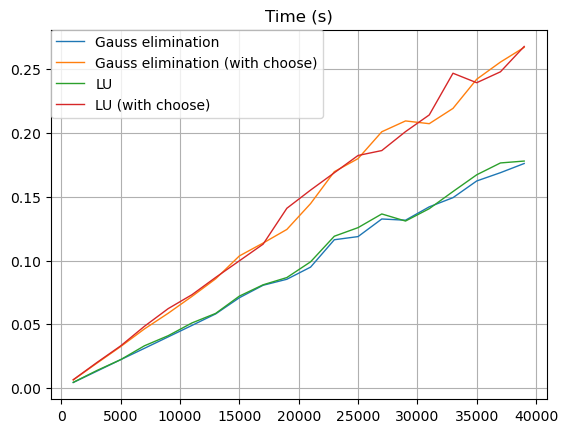

PyObject Text(0.5, 1.0, 'Time (s)')

In [81]:
clf()
plot(sizes, gauss_time, label="Gauss elimination", linewidth=1.0)
plot(sizes, gauss_choose_time, label="Gauss elimination (with choose)", linewidth=1.0)
plot(sizes, lu_time, label="LU", linewidth=1.0)
plot(sizes, lu_choose_time, label="LU (with choose)", linewidth=1.0)
grid(true)
legend(loc=2,borderaxespad=0)
title("Time (s)")

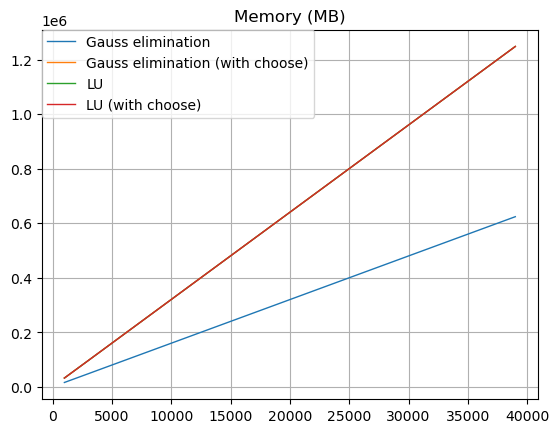

PyObject Text(0.5, 1.0, 'Memory (MB)')

In [82]:
clf()
plot(sizes, gauss_mem, label="Gauss elimination", linewidth=1.0)
plot(sizes, gauss_choose_mem, label="Gauss elimination (with choose)", linewidth=1.0)
plot(sizes, lu_mem, label="LU", linewidth=1.0)
plot(sizes, lu_choose_mem, label="LU (with choose)", linewidth=1.0)
grid(true)
legend(loc=2,borderaxespad=0)
title("Memory (MB)")